In [2]:
import pandas as pd
import numpy as np
import yaml
import pycountry
import pycountry_convert as pc
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
data_swissre = pd.read_csv('./data/swissre/swissre_data_with_vax.csv', parse_dates=['date']).set_index('date')

- Cases: cumulative
- Deaths: cumulative
- New cases: daily
- New deaths: daily
- Recovered: difference (entered - exited)
- Stats on population divided per age: 52% null
- Fatality rate percentage: total deaths / total cases. Problem: should be shifted
- Days since outbreak can be used instead of a fixed 04-01 date (maybe one month after the first outbreak?)
- real_unemployment_rate_growth: 79% of null. Can't be used together with non-life and life premium growth.
- am_fear_factor_index ???
- Unemployment rate: many nulls but seems good. Also, 2021 is forecast.
- Gdp quarterly: same-> many nans but good indicator
- covid19_reopen_criteria_14_day_new_cases_downward_trajectory: ??? Can be seen as policy?
- Stage number: 9 levels for the stage of the pandemic. Hovering = null (maybe replace with 0)
- epiforecasts_effective_reproduction_number_median: median of the rep. number, it is right to report it. Taking also 90% CI and 50% CI
- Maybe look at projections

**TO ADD**: 
- Population density
- Median age
- Human development index
- Diabetes prevalence
- Life expectancy

Weather: to use or not to use? 
Policies: boolean or level? 


# Selecting columns for the first model

In [3]:
with open('config/swissre_features.yaml', 'r', encoding='utf-8') as file:
    swissre_features = yaml.load(file, Loader=yaml.FullLoader)

In [4]:
columns_to_use= swissre_features['main'] +\
            swissre_features['demography'] +\
            swissre_features['sanitary'] +\
            swissre_features['weather'] +\
            swissre_features['economic']['to_use'] +\
            swissre_features['vaccines']['to_use'] +\
            swissre_features['policies']['to_use'] +\
            swissre_features['outcomes']['to_use'] + ['cases']         

outcome = 'epiforecasts_effective_reproduction_number_median' # r_estim epiforecasts_effective_reproduction_number_median

In [5]:
df = data_swissre[columns_to_use].copy()
df.columns

Index(['name', 'iso_code', 'total_population_all', 'total_population_below_1',
       'total_population_1_to_4', 'total_population_5_to_14',
       'total_population_15_to_24', 'total_population_25_to_34',
       'total_population_35_to_54', 'total_population_55_to_74',
       'total_population_above_75', 'population_percentage_over_60',
       'hospital_beds_per_1000', 'physicians_per_1000', 'nurses_per_1000',
       'maxtempC', 'mintempC', 'tempC', 'FeelsLikeC', 'humidity', 'pressure',
       'HeatIndexC', 'uvIndex', 'totalSnow_cm', 'sunHour', 'windspeedKmph',
       'precipMM', 'unemployment_rate_2020_03_31',
       'unemployment_rate_2020_06_30', 'unemployment_rate_2020_09_30',
       'unemployment_rate_2020_12_31', 'unemployment_rate_2021_03_31',
       'unemployment_rate_2021_06_30', 'unemployment_rate_2021_09_30',
       'unemployment_rate_2021_12_31', 'unemployment_rate_2019_03_31',
       'unemployment_rate_2019_06_30', 'unemployment_rate_2019_09_30',
       'unemployment_rate

In [32]:
# Taking the data starting from the 1st of april. ALTERNATIVE: use days since outbreak
df = df[df.index >= '2020-12-13'].sort_index() #2020-04-01

In [33]:
# Filtering for valid countries: 
def filter_valid_countries(data, min_ratio):
    iso_codes = []
    for iso_code in data.iso_code.unique():
        data_country = data[data.iso_code == iso_code]['epiforecasts_effective_reproduction_number_median'].dropna()
        n_values = data_country.shape[0]

    # If rows exist for that country with a valid r_estim value
        if n_values > 0:
            n_days = (data_country.index[-1] - data_country.index[0]).days + 1
            #print(n_days)
            ratio = n_values / n_days

            if ratio > min_ratio:
                iso_codes.append(iso_code)
            
    return data[data['iso_code'].isin(iso_codes)]

df = filter_valid_countries(df, 0.9)

In [34]:
print(f"Number of countries: {len(df.iso_code.unique())}")

Number of countries: 161


In [35]:
# Putting NaN where the estimated reproduction number is larger than 4
df[outcome] = np.where(df[outcome] >= 4, np.nan, df[outcome])

In [36]:
# Shifting the reproduction rate by 11 days for each country
df['date_index'] = df.index
df = df.sort_values(by = ['iso_code', 'date_index'])

if outcome == 'r_estim':
    df['shifted_r_estim'] = df[outcome].shift(-11).where(df['iso_code'].eq(df['iso_code'].shift(-11)))
else:
    # Already shifted by default
    df['shifted_r_estim'] = df[outcome]
    

In [37]:
# retaining only the countries that exceeded 2000 casese
iso_codes = list(df[df['cases'] > 2000]['iso_code'].unique())
df = df[df['iso_code'].isin(iso_codes)]
print(f"Number of countries: {len(df.iso_code.unique())}")

Number of countries: 161


**NOTE**: We are not dropping NaN values (we have to check what happens)

# Training the first model

In [38]:
from classes.context import Context
from classes.pipeline import Pipeline
from classes.plot import Plot

In [74]:
final_iso_code = 'CHE'

# Final training colums
train_cols= swissre_features['demography'] +\
            swissre_features['sanitary'] +\
            swissre_features['weather'] +\
            swissre_features['vaccines']['to_use'] +\
            swissre_features['economic']['to_use'] +\
            swissre_features['policies']['to_use'] #swissre_features['weather'] +\

final_train_cols = [col for col in train_cols if not df[df['iso_code'] == final_iso_code][col].isnull().all()]

In [75]:
list(set(train_cols) - set(final_train_cols))

[]

In [76]:
context = Context()

Global seed set to 42


In [77]:
pipeline = Pipeline(df, final_train_cols, 'shifted_r_estim', final_iso_code, 7, context) #shifted_r_estim
pipeline.fit_pipeline(save_model=False)

Global seed set to 42


Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 4.2 K 
1 | linear_1 | Linear | 2.4 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
7.7 K     Trainable params
0         Non-trainable params
7.7 K     Total params
0.031     Total estimated model params size (MB)
The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) 

.....................................

In [78]:
predictions = pipeline.predict()

plot = Plot(df, 'shifted_r_estim', final_iso_code, save_path='./plots/')

The mean average error was 0.0035410185063088585


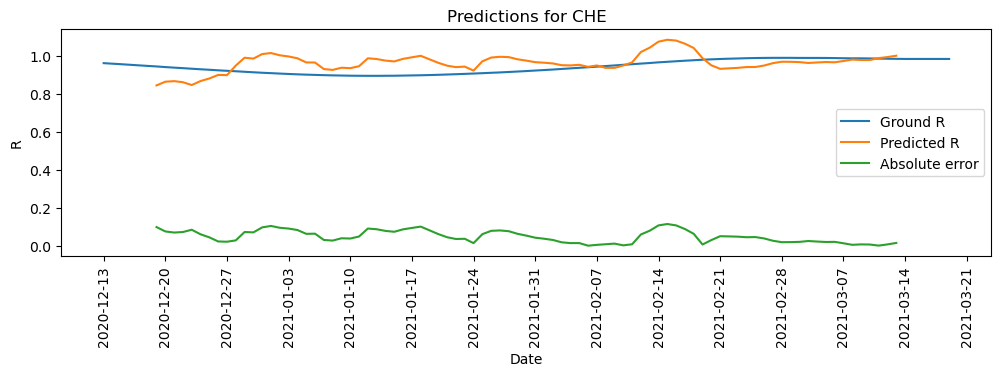

In [79]:
plot.plot_results(predictions, show = True)

invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


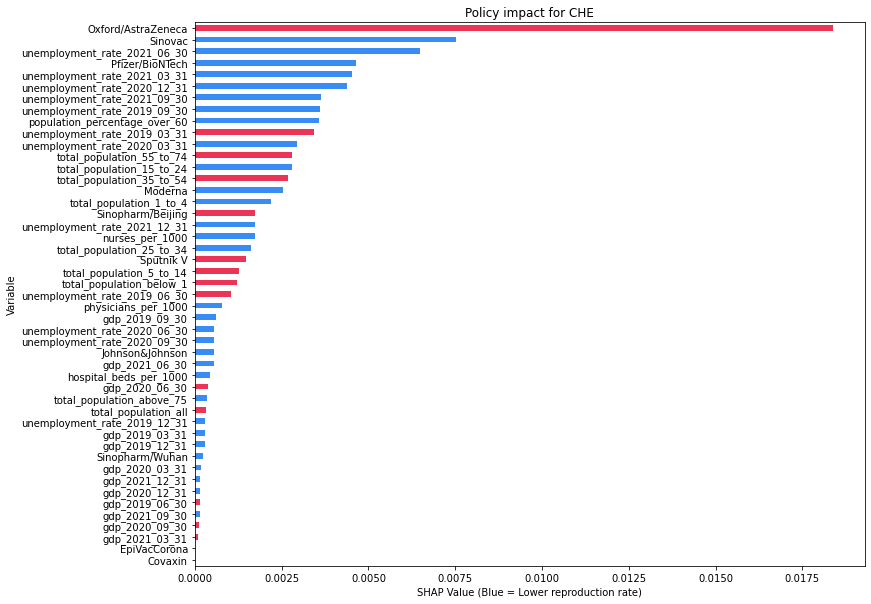

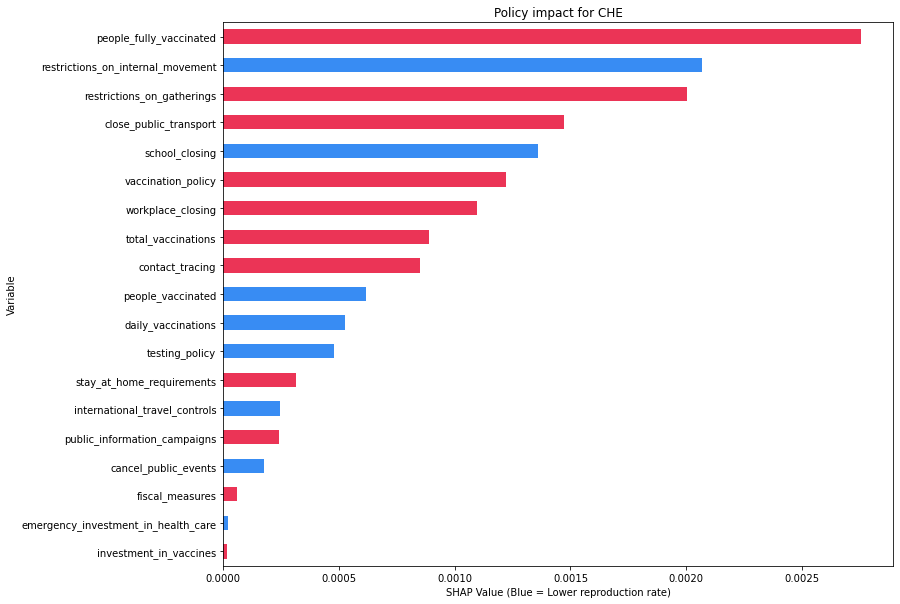

In [80]:
# Plotting shap
train, val = pipeline.get_data()

const_cols, var_cols = pipeline.get_cols()
plot.plot_shap(pipeline.get_model(), const_cols, var_cols, train, val, plot_bars=True, cols_to_drop = swissre_features['weather'])